## 쇼핑몰 사용자 고객 세분화 실습

- 해당 데이터를 고객 단위로 묶어야 합니다.


- 데이터를 정제해서, 월별/고객별로 재정렬이 필요합니다. (aggregation)


- row가 고객별 데이터로 묶이고 난 다음, 고객들을 유형별로 나눠봅니다.


- 여러 가지 클러스터링 알고리즘을 사용하여, 결과를 테스트해봅니다.


- 클러스터링을 위한 전처리부터, 평가까지 모든 항목을 하나하나 살펴보면서 데이터를 뜯어봅니다.

### Data Description

Source : https://www.kaggle.com/c/instacart-market-basket-analysis

### 1. 데이터 불러오기 

In [2]:
# instacart 데이터를 모두 불러옵니다.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

base_path = "C:/Users/gmlkd/data/instacart-market-basket-analysis/"

aisles = pd.read_csv(base_path+"aisles.csv")
departments = pd.read_csv(base_path+"departments.csv")
prior = pd.read_csv(base_path+"order_products__prior.csv")
train = pd.read_csv(base_path+"order_products__train.csv")
orders = pd.read_csv(base_path+"orders.csv")
products = pd.read_csv(base_path+"products.csv")

In [3]:
# 불러온 모든 테이블을 합칩니다.
print(aisles.shape, departments.shape, prior.shape, train.shape, orders.shape, products.shape)

(134, 2) (21, 2) (32434489, 4) (1384617, 4) (3421083, 7) (49688, 4)


In [11]:
prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [12]:
prior_sample = prior[:10000]
prior_sample

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
9995,1022,21903,1,1
9996,1022,38689,2,1
9997,1022,30391,3,1
9998,1022,18670,4,1


In [16]:
# prior_sample과 orders 합치기
temp = pd.merge(orders, prior_sample, on="order_id")
temp = pd.merge(temp, products, on="product_id")
temp = pd.merge(temp, aisles, on="aisle_id")
temp = pd.merge(temp, departments, on="department_id")
temp

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,40,382,prior,29,1,15,23.0,10070,1,1,Organic 1% Low Fat Milk,84,16,milk,dairy eggs
1,235,58701,prior,20,5,9,9.0,10070,7,1,Organic 1% Low Fat Milk,84,16,milk,dairy eggs
2,581,76141,prior,3,6,17,7.0,10070,3,0,Organic 1% Low Fat Milk,84,16,milk,dairy eggs
3,649,135836,prior,1,4,7,NaN,10070,1,0,Organic 1% Low Fat Milk,84,16,milk,dairy eggs
4,40,382,prior,29,1,15,23.0,34866,4,1,Chocolate Milk 1% Milkfat,84,16,milk,dairy eggs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,152,103040,prior,12,1,10,7.0,5161,3,1,Dried Mango,18,10,bulk dried fruits vegetables,bulk
9996,959,119941,prior,2,6,13,21.0,5161,3,1,Dried Mango,18,10,bulk dried fruits vegetables,bulk
9997,400,180454,prior,32,0,8,8.0,5161,3,1,Dried Mango,18,10,bulk dried fruits vegetables,bulk
9998,18,118860,prior,3,4,20,6.0,1000,3,0,Apricots,18,10,bulk dried fruits vegetables,bulk


### 2. EDA

In [24]:
# 10만개의 거래내역에 대해서 각 물품을 얼마나 샀을까?
# temp.user_id.value_counts()
# temp.product_name.value_counts()
# temp.aisle.value_counts()
temp.department.value_counts()
# temp.order_dow.value_counts()
# temp.order_hour_of_day.value_counts()

produce            2913
dairy eggs         1647
snacks              862
beverages           801
frozen              746
pantry              598
canned goods        362
bakery              354
deli                319
dry goods pasta     255
household           249
breakfast           238
meat seafood        225
babies              131
personal care       125
international        86
pets                 28
alcohol              27
missing              15
other                13
bulk                  6
Name: department, dtype: int64

### 3. 데이터 전처리

- 데이터를 transaction 단위로 변경합니다.

- 각자의 방법대로 데이터의 단위를 정해봅시다.


> User 단위로 어떤 물품을 구매했는지의 정보만 가지는 feature vector로 변환한다. e.g. pd.crosstab, CountVectorizer

In [25]:
# transaction -> user-level 단위로 변경하고, User당 정보로 변환하는 과정까지 마무리합니다.
# 1. Department(v)     2. aisle        3. Product_name

X = pd.crosstab(index = temp.user_id, columns=temp.department)
X

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
user_id,,,,,,,,,,,,,,,,,,,,,
382,0,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
503,0,0,0,0,1,0,2,1,0,0,...,0,0,1,0,0,1,0,0,2,0
971,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1059,0,0,3,0,3,0,0,8,0,0,...,0,1,2,0,0,2,0,0,8,2
1177,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204184,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
204484,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,4,1
204912,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,1,0


### 4. 클러스터링 모델 적용하기

- 사용하는 클러스터링 모델은 KMeans로 합니다.

(원하시면 AgglomerativeClustering, DBSCAN, SpectralClustering을 사용해보셔도 됩니다. 단, 시간이 매우매우 오래 걸릴수 있으니 주의하세요..)

**[K-Means]**

- Elbow method를 이용하여 최적의 K값을 찾아보세요.


- sparse한 특징을 가지는 데이터를 클러스터링 하기 위해서는 어떤 기법을 사용해야 할까요?


- 클러스터링 결과를 시각화해보고, 실루엣 지수도 계산해봅시다.

In [26]:
# data setting
X

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
user_id,,,,,,,,,,,,,,,,,,,,,
382,0,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
503,0,0,0,0,1,0,2,1,0,0,...,0,0,1,0,0,1,0,0,2,0
971,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1059,0,0,3,0,3,0,0,8,0,0,...,0,1,2,0,0,2,0,0,8,2
1177,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204184,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
204484,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,4,1
204912,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,1,0


In [27]:
# tSNE : 시각화용도의 차원감소 기법. (2차원으로 변환해주는 기법)
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(X)
tsne_data

C:\Users\gmlkd\miniforge3\envs\fastcampus\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\gmlkd\miniforge3\envs\fastcampus\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


array([[  0.2444466, -27.278698 ],
       [ -7.7070374,  -6.715037 ],
       [-17.197998 , -17.034048 ],
       ...,
       [ -1.6706865, -13.99445  ],
       [ -1.7386459, -34.61212  ],
       [ 11.536472 ,   4.6104918]], dtype=float32)

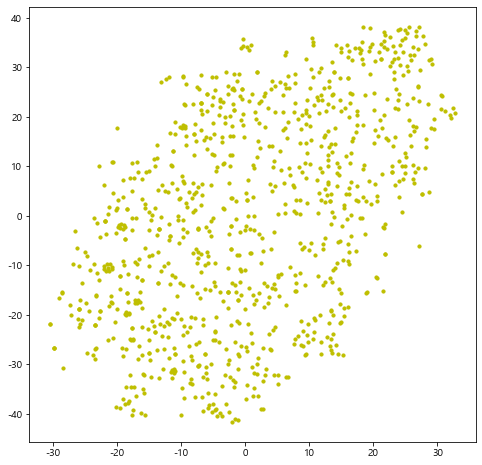

In [28]:
plt.figure(figsize=(8, 8))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], s=10, c='y')
plt.show()

In [36]:
# K-means로 최종확인 (k값 정하는게 중요)

# 1. K-means
from sklearn.cluster import KMeans
# 2. Hierarchical Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering
# 3. DBSCAN
from sklearn.cluster import DBSCAN
# 4. Spectral Clustering
from sklearn.cluster import SpectralClustering

from sklearn.metrics import silhouette_score

model = KMeans(n_clusters=4)
model2 = KMeans(n_clusters=2)

# unsupervised setting
# fit + predict
pred = model.fit_predict(X)
pred2 = model2.fit_predict(X)

# 1일수록 좋음
print("S-Score: %.4f" %silhouette_score(X, pred))
print("S-Score: %.4f" %silhouette_score(X, pred2))

S-Score: 0.1915
S-Score: 0.3641


In [31]:
# elbow method
sse = []
silhouettes = []

for K in range(2, 11):
    model = KMeans(n_clusters=K) # K=2~10
    pred = model.fit_predict(X)
    sse.append(model.inertia_)     # SSE값
    silhouettes.append(silhouette_score(X, pred))

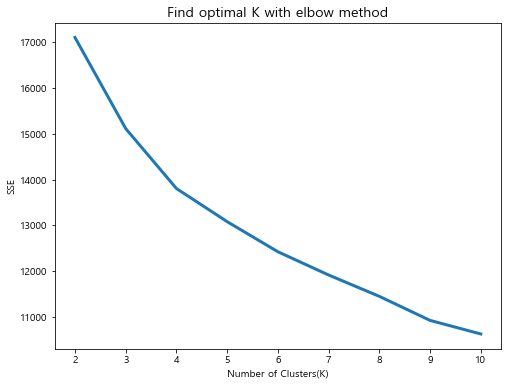

In [33]:
# 최적의 K는 어떻게 구할까요?
# Elbow method : 정해진 K에 대해서 SSE를 계산한 다음, SSE가 가장 많이 꺾이는 K(elbow)가 optimal K라고 판단하는 방법.

plt.figure(figsize=(8, 6))
plt.title("Find optimal K with elbow method", fontsize=14)
plt.xlabel("Number of Clusters(K)", fontsize=10)
plt.ylabel("SSE", fontsize=10)
plt.plot(range(2, 11), sse, lw=3)
plt.show()

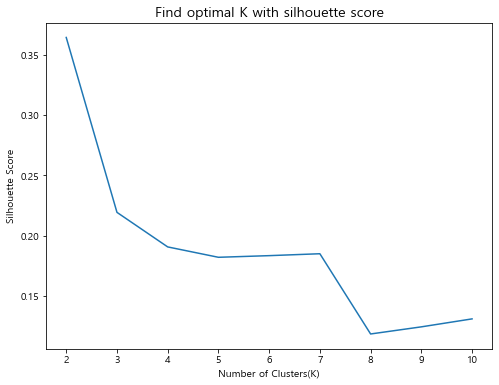

In [35]:
# Silhouette score : 같은 클러스터에 속하는 데이터중 가장 먼 데이터와의 거리와 다른 클러스터에 속하는 데이터 중 가장 가까운 데이터와의 거리 비율을 계산한 지표. [-1, 1]
# Reference : https://en.wikipedia.org/wiki/Silhouette_(clustering)

## K기준으로 4가 Best, 실루엣 score기준으로 2가 Best

plt.figure(figsize=(8, 6))
plt.title("Find optimal K with silhouette score", fontsize=14)
plt.xlabel("Number of Clusters(K)", fontsize=10)
plt.ylabel("Silhouette Score", fontsize=10)
plt.plot(range(2, 11), silhouettes)
plt.show()

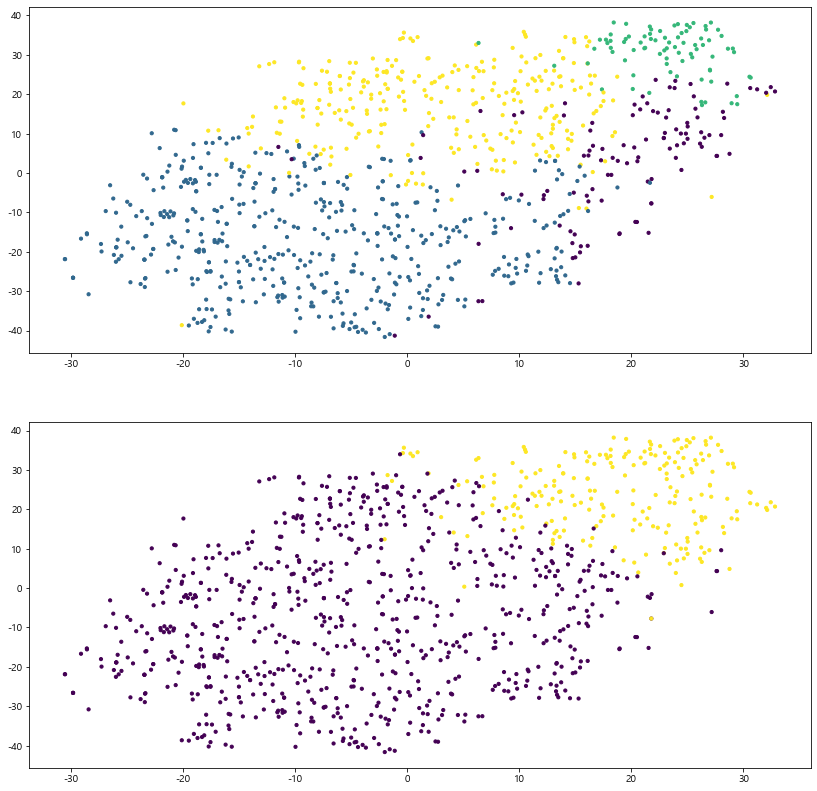

In [43]:
plt.figure(figsize=(14, 14))
plt.subplot(211)
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], s=10, c=pred, cmap="viridis")
plt.subplot(212)
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], s=10, c=pred2, cmap="viridis")

plt.show()

In [50]:
# see summary
X['cluster_label'] = pred2
X['Cluster_label'] = pred
X

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,meat seafood,missing,other,pantry,personal care,pets,produce,snacks,cluster_label,Cluster_label
user_id,,,,,,,,,,,,,,,,,,,,,
382,0,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,1
503,0,0,0,0,1,0,2,1,0,0,...,1,0,0,1,0,0,2,0,0,1
971,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
1059,0,0,3,0,3,0,0,8,0,0,...,2,0,0,2,0,0,8,2,1,0
1177,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,2,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204184,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
204484,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,4,1,0,3
204912,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,1,0,0,1


In [55]:
# pred2
group1 = X.loc[X.cluster_label == 0, :]
group2 = X. loc[X.cluster_label == 1, :]

print(group1.shape, group2.shape)

(750, 23) (222, 23)


In [56]:
group1.mean()
# produce > dairy eggs > snacks ..

department
alcohol            0.033333
babies             0.105333
bakery             0.297333
beverages          0.776000
breakfast          0.201333
bulk               0.002667
canned goods       0.282667
dairy eggs         1.273333
deli               0.241333
dry goods pasta    0.202667
frozen             0.653333
household          0.252000
international      0.073333
meat seafood       0.166667
missing            0.014667
other              0.016000
pantry             0.512000
personal care      0.129333
pets               0.026667
produce            1.668000
snacks             0.728000
cluster_label      0.000000
Cluster_label      1.458667
dtype: float64

In [57]:
group2.mean()
# produce > dairy eggs > beverages > ..

department
alcohol            0.009009
babies             0.234234
bakery             0.590090
beverages          0.986486
breakfast          0.391892
bulk               0.018018
canned goods       0.675676
dairy eggs         3.117117
deli               0.621622
dry goods pasta    0.463964
frozen             1.153153
household          0.270270
international      0.139640
meat seafood       0.450450
missing            0.018018
other              0.004505
pantry             0.963964
personal care      0.126126
pets               0.036036
produce            7.486486
snacks             1.423423
cluster_label      1.000000
Cluster_label      1.878378
dtype: float64

In [58]:
# pred

group1 = X.loc[X.Cluster_label == 0, :]
group2 = X. loc[X.Cluster_label == 1, :]
group3 = X.loc[X.Cluster_label == 2, :]
group4 = X. loc[X.Cluster_label == 3, :]


print(group1.shape, group2.shape, group3.shape, group4.shape)

(112, 23) (494, 23) (81, 23) (285, 23)


In [59]:
group1.mean()

department
alcohol            0.008929
babies             0.348214
bakery             0.839286
beverages          1.250000
breakfast          0.625000
bulk               0.000000
canned goods       0.508929
dairy eggs         4.776786
deli               0.508929
dry goods pasta    0.589286
frozen             1.803571
household          0.339286
international      0.178571
meat seafood       0.482143
missing            0.053571
other              0.008929
pantry             1.312500
personal care      0.303571
pets               0.062500
produce            3.571429
snacks             2.517857
cluster_label      0.500000
Cluster_label      0.000000
dtype: float64

In [60]:
group2.mean()

department
alcohol            0.040486
babies             0.085020
bakery             0.232794
beverages          0.771255
breakfast          0.176113
bulk               0.002024
canned goods       0.224696
dairy eggs         1.006073
deli               0.202429
dry goods pasta    0.176113
frozen             0.574899
household          0.259109
international      0.056680
meat seafood       0.131579
missing            0.006073
other              0.018219
pantry             0.433198
personal care      0.119433
pets               0.022267
produce            0.831984
snacks             0.629555
cluster_label      0.000000
Cluster_label      1.000000
dtype: float64

In [61]:
group3.mean()

department
alcohol             0.012346
babies              0.209877
bakery              0.567901
beverages           1.358025
breakfast           0.320988
bulk                0.037037
canned goods        0.765432
dairy eggs          2.987654
deli                0.864198
dry goods pasta     0.432099
frozen              1.296296
household           0.320988
international       0.135802
meat seafood        0.333333
missing             0.012346
other               0.000000
pantry              0.962963
personal care       0.098765
pets                0.074074
produce            10.654321
snacks              1.283951
cluster_label       1.000000
Cluster_label       2.000000
dtype: float64

In [62]:
group4.mean()

department
alcohol            0.017544
babies             0.115789
bakery             0.347368
beverages          0.596491
breakfast          0.192982
bulk               0.007018
canned goods       0.463158
dairy eggs         1.308772
deli               0.322807
dry goods pasta    0.235088
frozen             0.543860
household          0.200000
international      0.094737
meat seafood       0.277193
missing            0.017544
other              0.010526
pantry             0.557895
personal care      0.084211
pets               0.014035
produce            4.347368
snacks             0.578947
cluster_label      0.298246
Cluster_label      3.000000
dtype: float64